### **DOMAIN:**
Automotive. Surveillance.
### **CONTEXT:**
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is
predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of
the car, type, colour, number plates etc.
### **DATA DESCRIPTION:**
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing
images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g.
2012 Tesla Model S or 2012 BMW M3 coupe.
#### **Data description:**
* **Train Images:** Consists of real images of cars as per the make and year of the 
car.
* **Test Images:** Consists of real images of cars as per the make and year of the car.
* **Train Annotation:** Consists of bounding box region for training images.
* **Test Annotation:** Consists of bounding box region for testing images.
Dataset has been attached along with this project. Please use the same for this capstone project.
<br>Original link to the dataset: https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder
<br>Reference: 3D Object Representations for Fine-Grained Categorisation, Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei 4th IEEE
Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.

### **OBJECTIVE:**
Design a DL based car identification model.

### **CNN Model - RESENT-34**

In [1]:
# Imports here
import pandas as pd
# Initialize the random number generator
import random
random.seed(0)
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as patches
import os
import cv2



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining Project Path

In [3]:
project_path = '/content/drive/My Drive/AIML/Capstone Project/'

In [4]:
class_names_data = pd.read_csv(project_path+"names.csv", header=None, names=["class_name"])
train_annotate = pd.read_csv(project_path+"anno_train.csv", header=None, names=["image_file","x0","y0","x1","y1","class"])
test_annotate = pd.read_csv(project_path+"anno_test.csv", header=None, names=["image_file","x0","y0","x1","y1","class"])

In [5]:
#Showing Top 10 label of Class Name
class_names_data.head(10)

,class_name
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
5,Acura Integra Type R 2001
6,Acura ZDX Hatchback 2012
7,Aston Martin V8 Vantage Convertible 2012
8,Aston Martin V8 Vantage Coupe 2012
9,Aston Martin Virage Convertible 2012


In [6]:
#Showing Top 10 label of Train Annotation
train_annotate.head(10)

,image_file,x0,y0,x1,y1,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106
5,00006.jpg,259,289,515,416,123
6,00007.jpg,88,80,541,397,89
7,00008.jpg,73,79,591,410,96
8,00009.jpg,20,126,1269,771,167
9,00010.jpg,21,110,623,367,58


In [7]:
#Showing Top 10 label of Test Annotation
test_annotate.head(10)

,image_file,x0,y0,x1,y1,class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185
5,00006.jpg,20,77,420,301,78
6,00007.jpg,249,166,2324,1459,118
7,00008.jpg,119,215,1153,719,165
8,00009.jpg,1,7,275,183,32
9,00010.jpg,28,55,241,177,60


In [8]:
#Showing Example of Class Name Which contains Make, Model, Type, Year
class_names_data['class_name'][196%195]

'Acura RL Sedan 2012'

In [9]:
train_annotate['class_name'] = train_annotate.apply(lambda x: class_names_data['class_name'][x['class']%len(class_names_data['class_name'])], axis=1)

In [10]:
#Showing mapping train annotation file
train_annotate

,image_file,x0,y0,x1,y1,class,class_name
0,00001.jpg,39,116,569,375,14,Audi R8 Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Type-S 2008
2,00003.jpg,85,109,601,381,91,Dodge Magnum Wagon 2008
3,00004.jpg,621,393,1484,1096,134,Hyundai Elantra Sedan 2007
4,00005.jpg,14,36,133,99,106,Ford Mustang Convertible 2007
...,...,...,...,...,...,...,...
8139,08140.jpg,3,44,423,336,78,Chrysler 300 SRT-8 2010
8140,08141.jpg,138,150,706,523,196,AM General Hummer SUV 2000
8141,08142.jpg,26,246,660,449,163,Mercedes-Benz E-Class Sedan 2012
8142,08143.jpg,78,526,1489,908,112,Ford F-150 Regular Cab 2012


Defining Image Path

In [11]:
def get_image_file_list(image_path):
  train_image_dir = os.listdir(image_path)
  train_image_list=[]
  for i in train_image_dir:
    for f in os.listdir(os.path.join(image_path, i)):
              # Check file extension. Allow only jpg/jpeg' files.
              ext = os.path.splitext(f)[1]
              if ext == '.jpg' or ext == '.jpeg':
                train_image_list.append("{}/{}".format(i,f))
  return train_image_list

In [12]:
def map_image_metadata(image_base_path, annotate_metadata, image_path_list):
  image_path_lst_split = [i.split('/')[1] for i in image_path_list]
  annotate_metadata["train_image_path"] = annotate_metadata.apply(
      lambda row: image_base_path+'/'+ image_path_list[image_path_lst_split.index(row['image_file'])], 
      axis=1)
  return annotate_metadata

Mapping Training Annoatation and Image Path

In [13]:
train_image_path = project_path+"car_data/car_data/train"
train_image_list = get_image_file_list(train_image_path)
train_annotate = map_image_metadata(train_image_path, train_annotate, train_image_list)

In [14]:
train_annotate.head(10)

,image_file,x0,y0,x1,y1,class,class_name,train_image_path
0,00001.jpg,39,116,569,375,14,Audi R8 Coupe 2012,/content/drive/My Drive/AIML/Capstone Project/...
1,00002.jpg,36,116,868,587,3,Acura TL Type-S 2008,/content/drive/My Drive/AIML/Capstone Project/...
2,00003.jpg,85,109,601,381,91,Dodge Magnum Wagon 2008,/content/drive/My Drive/AIML/Capstone Project/...
3,00004.jpg,621,393,1484,1096,134,Hyundai Elantra Sedan 2007,/content/drive/My Drive/AIML/Capstone Project/...
4,00005.jpg,14,36,133,99,106,Ford Mustang Convertible 2007,/content/drive/My Drive/AIML/Capstone Project/...
5,00006.jpg,259,289,515,416,123,HUMMER H3T Crew Cab 2010,/content/drive/My Drive/AIML/Capstone Project/...
6,00007.jpg,88,80,541,397,89,Dodge Dakota Crew Cab 2010,/content/drive/My Drive/AIML/Capstone Project/...
7,00008.jpg,73,79,591,410,96,Dodge Charger SRT-8 2009,/content/drive/My Drive/AIML/Capstone Project/...
8,00009.jpg,20,126,1269,771,167,Nissan Leaf Hatchback 2012,/content/drive/My Drive/AIML/Capstone Project/...
9,00010.jpg,21,110,623,367,58,Chevrolet Camaro Convertible 2012,/content/drive/My Drive/AIML/Capstone Project/...


Defining Show Image Function

In [15]:
def show_image(metadata):
  img = cv2.imread(metadata['train_image_path'],1)
  plt.imshow(img)
  plt.show()

Defining Bounding Box function

In [16]:
def show_image_with_bb(df):
  img = cv2.imread(df.train_image_path,1)
  x0=df.x0
  x1=df.x1
  y0=df.y0
  y1=df.y1

  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = patches.Rectangle((x0,y0), (x1-x0),(y1-y0),
                          linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.title(df.class_name)
  plt.show()

In [17]:
df = train_annotate.iloc[8]
df

image_file                                                  00009.jpg
x0                                                                 20
y0                                                                126
x1                                                               1269
y1                                                                771
class                                                             167
class_name                                 Nissan Leaf Hatchback 2012
train_image_path    /content/drive/My Drive/AIML/Capstone Project/...
Name: 8, dtype: object

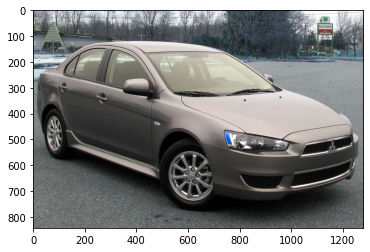

In [18]:
show_image(df)

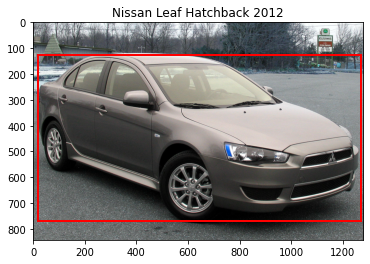

In [19]:
show_image_with_bb(df)

In [20]:
test_annotate['class_name'] = test_annotate.apply(lambda x: class_names_data['class_name'][x['class']%len(class_names_data['class_name'])], axis=1)

In [21]:
test_image_path = project_path+"car_data/car_data/test"
test_image_list = get_image_file_list(test_image_path)
test_annotate = map_image_metadata(test_image_path, test_annotate, test_image_list)

In [22]:
df = test_annotate.iloc[10]
df

image_file                                                  00011.jpg
x0                                                                 30
y0                                                                 20
x1                                                                438
y1                                                                253
class                                                              49
class_name                                     Buick Enclave SUV 2012
train_image_path    /content/drive/My Drive/AIML/Capstone Project/...
Name: 10, dtype: object

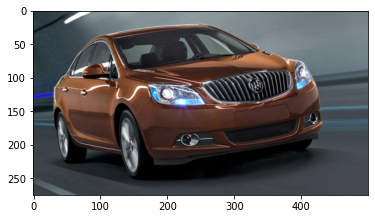

In [23]:
show_image(df)

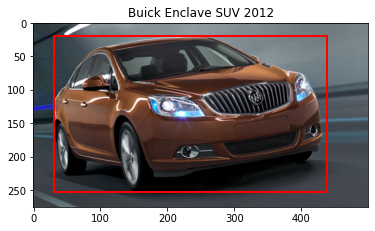

In [24]:
show_image_with_bb(df)

In [25]:
d = test_annotate.iloc[2]
d

image_file                                                  00003.jpg
x0                                                                 51
y0                                                                105
x1                                                                968
y1                                                                659
class                                                             145
class_name                                     Jeep Wrangler SUV 2012
train_image_path    /content/drive/My Drive/AIML/Capstone Project/...
Name: 2, dtype: object

#### Building RESNET Model

In [28]:
data_dir = '/content/drive/My Drive/AIML/Capstone Project/car_data/car_data/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/test'
test_dir = data_dir + '/test'

#### Step 2: Transform the Dataset

In [29]:
# Training transform includes random rotation and flip to build a more robust model
train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# The validation set will use the same transform as the test set
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = transforms.Compose([transforms.Resize((244,244)),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/test', transform=validation_transforms)

# Using the image datasets and the trainforms, define the dataloaders
# The trainloader will have shuffle=True so that the order of the images do not affect the model
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)

#### Step 3: Create Model

In [30]:
#model = models.densenet121(pretrained=True)
model = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [31]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

#### Step 4: Train Model

In [33]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    
    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
    
        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [34]:
epochs = 10
steps = 0
print_every = 40

# change to gpu mode
model.to('cuda')
model.train()
for e in range(epochs):

    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()
            
            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")
            
            
            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)

No. epochs: 1,             Training Loss: 5.172             Valid Loss: 4.686             Valid Accuracy: 0.056
No. epochs: 2,             Training Loss: 1.487             Valid Loss: 3.478             Valid Accuracy: 0.219
No. epochs: 2,             Training Loss: 1.487             Valid Loss: 3.478             Valid Accuracy: 0.219
No. epochs: 2,             Training Loss: 4.619             Valid Loss: 2.59             Valid Accuracy: 0.362
No. epochs: 2,             Training Loss: 4.619             Valid Loss: 2.59             Valid Accuracy: 0.362
No. epochs: 3,             Training Loss: 1.736             Valid Loss: 2.055             Valid Accuracy: 0.484
No. epochs: 3,             Training Loss: 1.736             Valid Loss: 2.055             Valid Accuracy: 0.484
No. epochs: 4,             Training Loss: 0.286             Valid Loss: 1.68             Valid Accuracy: 0.565
No. epochs: 4,             Training Loss: 0.286             Valid Loss: 1.68             Valid Accuracy: 0.

In [35]:
correct = 0
total = 0
model.to('cuda')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 75.948%


In [37]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Step 5: Save the Model

In [38]:
# Saving: feature weights, new model.fc, index-to-class mapping, optimiser state, and No. of epochs
checkpoint = {'state_dict': model.state_dict(),
              'model': model.fc,
              'class_to_idx': train_data.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}

torch.save(checkpoint, '/content/drive/My Drive/AIML/Capstone Project/my_checkpoint1.pth')

In [ ]:
json_file = model.to_json()
with open(project_path+"classification_mobilenet.json", "w") as file:
   file.write(json_file)
# serialize weights to HDF5
model.save_weights(project_path+"classification_mobilenet.h5")

#### Step 6: Load the Model

In [39]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)
    
    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [40]:

# Loading model
model = load_checkpoint('/content/drive/My Drive/AIML/Capstone Project/my_checkpoint1.pth')
# Checking model i.e. should have 196 output units in the classifier
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Step 7: Predict the Image

In [41]:
def process_image(image):
    
    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
    
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd)
    
    return array_im_tfd

In [42]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

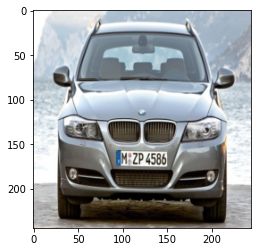

In [48]:
imshow(process_image(data_dir + 'train/BMW 3 Series Wagon 2012/04410'))

In [49]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file   
    
    # Loading model - using .cpu() for working with CPUs
    loaded_model = load_checkpoint(model).cpu()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)
        
    #conf, predicted = torch.max(output.data, 1)   
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]
    
    # Converting probabilities and outputs to lists
    conf = np.array(probs_top)[0]
    predicted = np.array(predicted_top)[0]
        
    #return probs_top_list, index_top_list
    return conf, predicted

In [50]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(data_dir+"train")

print(classes, c_to_idx)

['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW Z4 Convertible 2012

#### Step 8: Show the result

In [52]:
model_path = '/content/drive/My Drive/AIML/Capstone Project/my_checkpoint1.pth'
image_path = data_dir +'train/BMW 3 Series Wagon 2012/04410'


conf1, predicted1 = predict(image_path, model_path, topk=5)

print(conf1)
print(classes[predicted1[0]])


[3.8187773 3.5564532 3.533694  3.2473457 2.997719 ]
Jaguar XK XKR 2012


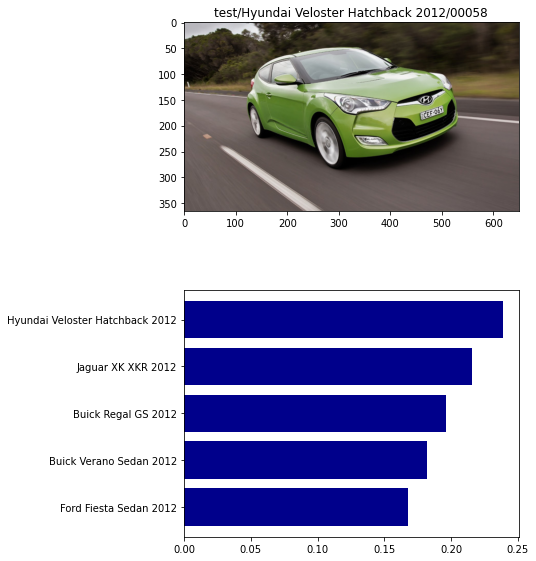

In [55]:
# Testing predict function

# Inputs are paths to saved model and test image
model_path = '/content/drive/My Drive/AIML/Capstone Project/my_checkpoint1.pth'
carname =  'test/Hyundai Veloster Hatchback 2012/00058'
image_path = data_dir + carname


conf2, predicted1 = predict(image_path, model_path, topk=5)
# Converting classes to names
names = []
for i in range(5):
  
    names += [classes[predicted1[i]]]

# Creating PIL image
image = Image.open(image_path+'.jpg')

# Plotting test image and predicted probabilites
f, ax = plt.subplots(2,figsize = (6,10))

ax[0].imshow(image)
ax[0].set_title(carname)

y_names = np.arange(len(names))
ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
ax[1].set_yticks(y_names)
ax[1].set_yticklabels(names)
ax[1].invert_yaxis() 

plt.show()

In [56]:
def plot_solution(cardir, model):
  # Testing predict function

  # Inputs are paths to saved model and test image
  model_path = '/content/drive/My Drive/AIML/Capstone Project/my_checkpoint1.pth'
  image_path = test_dir + cardir
  carname = cardir.split('/')[1]

  conf2, predicted1 = predict(image_path, model_path, topk=5)
  # Converting classes to names
  names = []
  for i in range(5):
  
      names += [classes[predicted1[i]]]


  # Creating PIL image
  image = Image.open(image_path+'.jpg')

  # Plotting test image and predicted probabilites
  f, ax = plt.subplots(2,figsize = (6,10))

  ax[0].imshow(image)
  ax[0].set_title(carname)

  y_names = np.arange(len(names))
  ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
  ax[1].set_yticks(y_names)
  ax[1].set_yticklabels(names)
  ax[1].invert_yaxis() 

  plt.show()

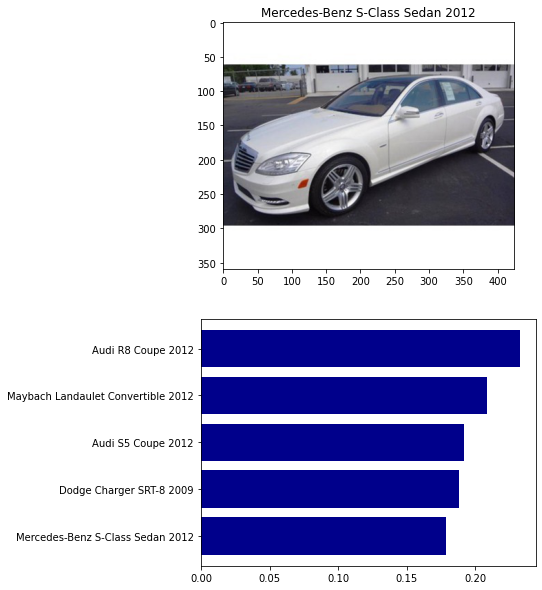

In [57]:
cardir='/Mercedes-Benz S-Class Sedan 2012/06543'
plot_solution(cardir, model)

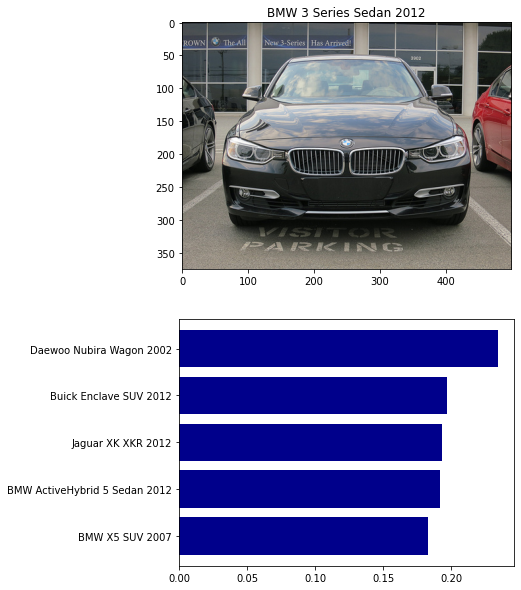

In [58]:
cardir='/BMW 3 Series Sedan 2012/06582'
plot_solution(cardir, model)

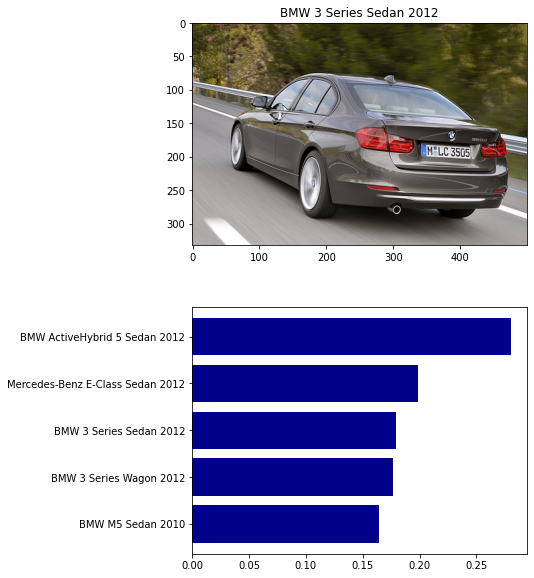

In [59]:
cardir='/BMW 3 Series Sedan 2012/06544'
plot_solution(cardir, model)

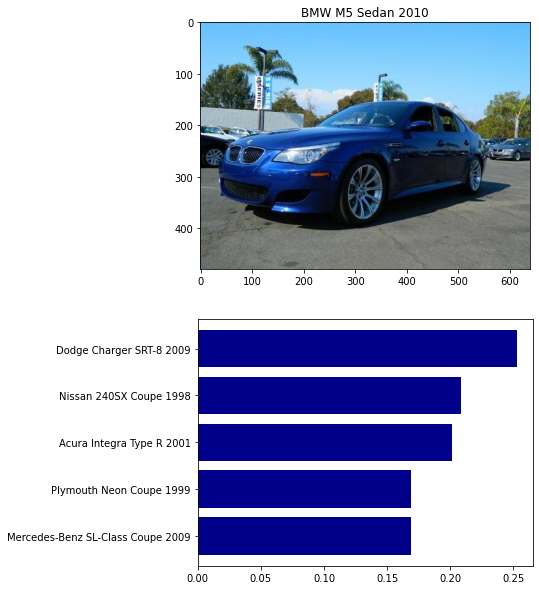

In [60]:
cardir='/BMW M5 Sedan 2010/03529'
plot_solution(cardir, model)

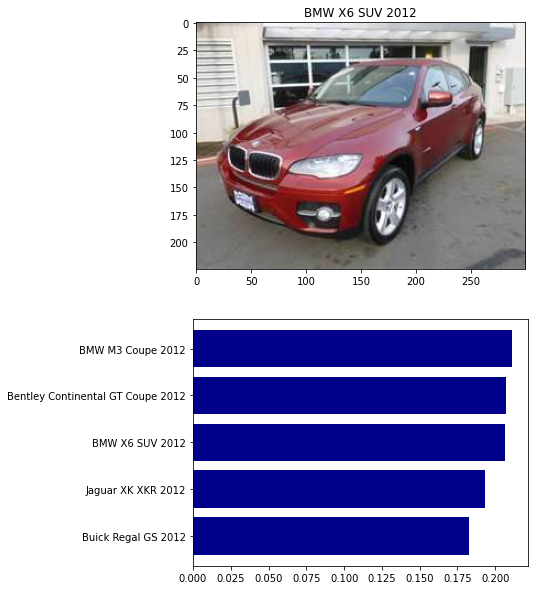

In [61]:
cardir='/BMW X6 SUV 2012/02891'
plot_solution(cardir, model)

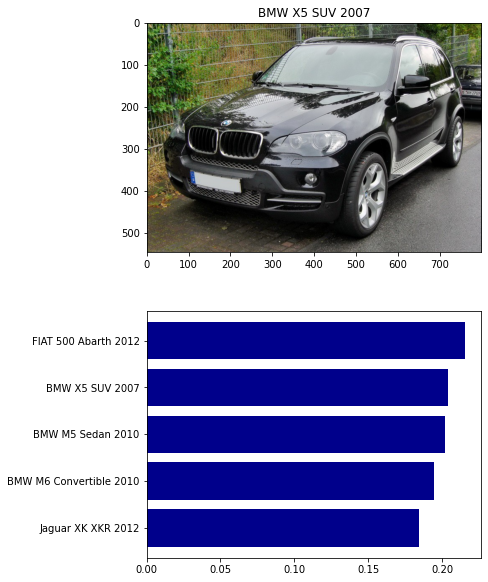

In [62]:
cardir='/BMW X5 SUV 2007/03310'
plot_solution(cardir, model)

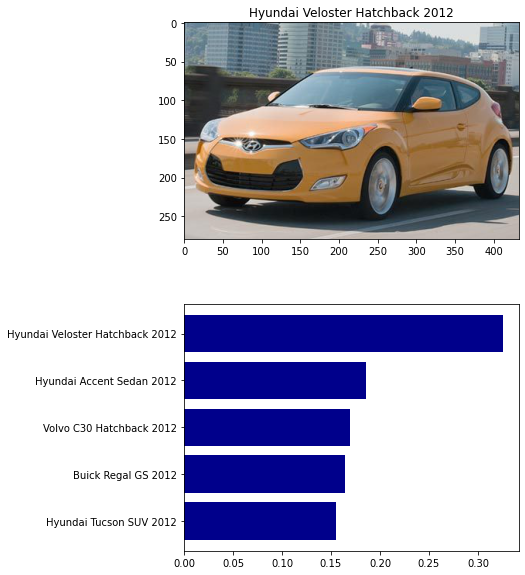

In [63]:
cardir='/Hyundai Veloster Hatchback 2012/06652'
plot_solution(cardir, model)

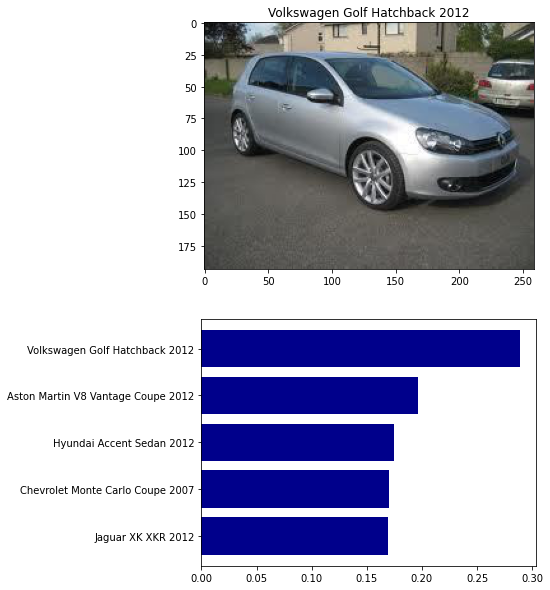

In [64]:
cardir='/Volkswagen Golf Hatchback 2012/06875'
plot_solution(cardir, model)

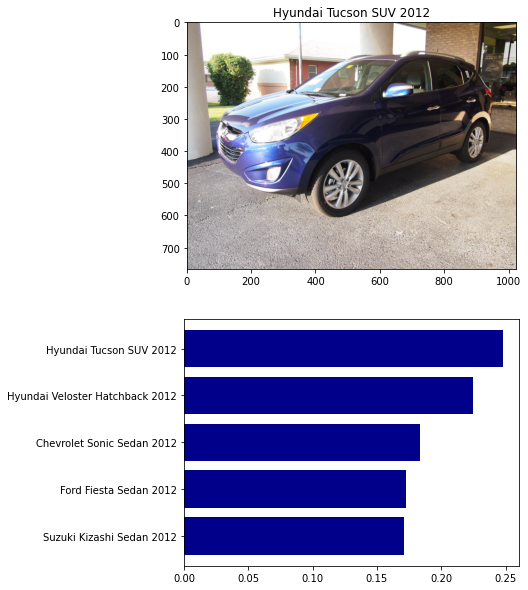

In [65]:
cardir='/Hyundai Tucson SUV 2012/07220'
plot_solution(cardir, model)